# Exercise 5 : Neural machine Translation with `nn.Transformer` and Multi30k dataset
========================================================

**USI, Deep Learning lab SA 2025-2026**

Lecturer: Eleonora Vercesi. TAs: Alvise Dei Rossi, Stefano Huber, Lorenzo Scarciglia

========================================================

In this exercise we're going to tackle a "simple" (toy) machine translation task with a full transformer model, implemented with Pytorch.
We will use the [Multi30k dataset from HuggingFace](https://huggingface.co/datasets/bentrevett/multi30k) that
yields a pair of source-target raw sentences (source: German, target: English). Originally this dataset was introduced by researchers to stimulate multilingual multimodal research (sentences are image descriptions, [link to article](https://arxiv.org/abs/1605.00459)). It includes approximately 30 thousand sentence-pairs, hence the name.

In this example, we show how to load the dataset, tokenize raw text sentences,
build vocabulary, and numericalize tokens into tensor. We'll then built the transformer model and train it onto the processed data.

For comparison the original Trasformer model (which is not too far with respect to the implementation we'll see today) discussed in the paper "[Attention is all you need](https://user.phil.hhu.de/~cwurm/wp-content/uploads/2020/01/7181-attention-is-all-you-need.pdf)" was instead trained on the WMT 2014 English-German dataset consisting of 4.5M sentence pairs, with 37k tokens and on 8 NVIDIA P100 GPUs for 12 hours.

# Libraries version & Tokenizer download
====================

**Note**: You **SHOULD definitely** use a GPU for this exercise; we'll use Colab GPUs but if you finished your GPU time on Colab, you can also run this notebook on Kaggle or Lightning.

The following versioning configuration will throw an error but this shouldn't be relevant for running the rest of the notebook. Keep it unchanged.

In this notebook we'll download the tokenizer, focusing more on the architecture of the model; but of course you could tokenize the sentences with custom tokenizers.

We'll leverage one tokenizer for each language. More in detail, we leverage the original BERT tokenizer to tokenize the English sentences (https://huggingface.co/google-bert/bert-base-cased), and the German version to tokenize the German sentences (https://huggingface.co/google-bert/bert-base-german-cased).

In [ ]:
# !pip freeze | grep "torch"

In [ ]:
# !pip freeze | grep "transformers"

sentence-transformers==5.1.2
transformers==4.57.2


In [ ]:
# !pip freeze | grep "datasets"

In [1]:
!pip3 install torch==2.9.0 torchvision --index-url https://download.pytorch.org/whl/cu126 transformers==4.57.2 datasets==4.0.0

Looking in indexes: https://download.pytorch.org/whl/cu126


Data Downloading and Processing
============================

In [2]:
from datasets import load_dataset

# Load Multi30k from Hugging Face
hf_multi30k = load_dataset("bentrevett/multi30k")

print(hf_multi30k)

example = hf_multi30k["train"][0]

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

print("Example:", example)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})
Example: {'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}


In [3]:
# hf_multi30k['train'] = hf_multi30k['train'].select(range(100))

We're going first to get the tokenizers and vocabularies. We will use the pre-trained tokenizers from the English (the original) and German versions of BERT. These tokenizers use [WordPiece algorithm](https://huggingface.co/learn/llm-course/chapter6/6) to split words into sub-words.

In [4]:
from transformers import AutoTokenizer
tokenizer_src = AutoTokenizer.from_pretrained('google-bert/bert-base-german-cased')
tokenizer_tgt = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')

# We want to have the following special tokens: [UNK], [PAD], [BOS], [EOS].
# More in detail, BOS and EOS tokens are necessary in the decoding step. The former is the first token, while the latter is the last token produced in the autoregressive mode.
# Check whether if we have them, and manually add the remaining ones
print("Original tokenizer special map")
print("[SRC] tokenizer", tokenizer_src.special_tokens_map)
print("[TGT] tokenizer", tokenizer_tgt.special_tokens_map)
tokenizer_tgt.add_special_tokens({'eos_token':'[EOS]', 'bos_token':'[BOS]'}) # Special tokens need to match the keys in the list of predefined special attributes https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.add_special_tokens.special_tokens_dict
print("\nNew tokenizer special map")
print("[SRC] tokenizer", tokenizer_src.special_tokens_map) # No changes
print("[TGT] tokenizer", tokenizer_tgt.special_tokens_map)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Original tokenizer special map
[SRC] tokenizer {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
[TGT] tokenizer {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}

New tokenizer special map
[SRC] tokenizer {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
[TGT] tokenizer {'bos_token': '[BOS]', 'eos_token': '[EOS]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


In [5]:
# Once we have updated the vocabularies, we can retrieve the vocabularies
vocab_src = tokenizer_src.get_vocab()
vocab_tgt = tokenizer_tgt.get_vocab()

Let's make a couple examples:

In [6]:
print(f"[SRC] vocab size: {len(vocab_src)}")
print(f"[TGT] vocab size: {len(vocab_tgt)}")
src_terms = ['rotes', 'Auto']
tgt_terms = ['red', 'Car']
print('\n[SRC]')
for s in src_terms:
    try:
        print(f"{s}: {vocab_src[s]}")
    except Exception as e:
        print(f"'{s}' is not present in the vocabulary. However, the tokens are the following: {tokenizer_tgt.tokenize(s)}")
print('\n[TGT]')
for t in tgt_terms:
    try:
        print(f"{t}: {vocab_tgt[t]}")
    except Exception as e:
        print(f"'{t}' is not present in the vocabulary. However, the tokens are the following: {tokenizer_tgt.tokenize(t)}")

[SRC] vocab size: 30000
[TGT] vocab size: 28998

[SRC]
'rotes' is not present in the vocabulary. However, the tokens are the following: ['rot', '##es']
Auto: 3512

[TGT]
red: 1894
Car: 8185


In [7]:
# Save the special token mapping
special_token_mapping_src = {}
for i,j in zip(tokenizer_src.all_special_ids, tokenizer_src.all_special_tokens):
    special_token_mapping_src[j] = i
special_token_mapping_tgt = {}
for i,j in zip(tokenizer_tgt.all_special_ids, tokenizer_tgt.all_special_tokens):
    special_token_mapping_tgt[j] = i

print('[SRC]', special_token_mapping_src)
print('[TGT]', special_token_mapping_tgt)

[SRC] {'[UNK]': 2, '[SEP]': 4, '[PAD]': 0, '[CLS]': 3, '[MASK]': 5}
[TGT] {'[BOS]': 28997, '[EOS]': 28996, '[UNK]': 100, '[SEP]': 102, '[PAD]': 0, '[CLS]': 101, '[MASK]': 103}


In [8]:
PAD_IDX_SRC = special_token_mapping_src['[PAD]'] # tokenizer_src.pad_token_id
UNK_IDX_SRC = special_token_mapping_src['[UNK]'] # tokenizer_src.unk_token_id

PAD_IDX_TGT = special_token_mapping_tgt['[PAD]'] # tokenizer_tgt.pad_token_id
UNK_IDX_TGT = special_token_mapping_tgt['[UNK]'] # tokenizer_tgt.unk_token_id
BOS_IDX_TGT = special_token_mapping_tgt['[BOS]'] # tokenizer_tgt.bos_token_id
EOS_IDX_TGT = special_token_mapping_tgt['[EOS]'] # tokenizer_tgt.eos_token_id

PAD_IDX = PAD_IDX_TGT # Used by the loss function


In [9]:
BOS_IDX_TGT, EOS_IDX_TGT, PAD_IDX

(28997, 28996, 0)

Encoder Decoder Transformer Network
=================================

Transformer is a [sequence to sequence](https://proceedings.neurips.cc/paper/2014/hash/a14ac55a4f27472c5d894ec1c3c743d2-Abstract.html) model introduced in ["Attention is all you
need"](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
paper for machine translation tasks.

<img src="https://www.jeremyjordan.me/content/images/2023/05/multi-head-attention.png" height=500>
<img src="https://www.jeremyjordan.me/content/images/2023/05/transformer-architecture.png" height=700>


## Embedding and positional encoding

Below, we will create a
Seq2Seq network that uses Transformer. The network consists of three
parts. First part is the embedding layer. This layer converts tensor of
input indices into corresponding tensor of input embeddings. These
embedding are further augmented with positional encodings to provide
position information of input tokens to the model (more details [here](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)).

<img src="https://jalammar.github.io/images/t/transformer_positional_encoding_example.png" width=800 height=300>

In the following image Depth is the embedding size.

<img src="https://kazemnejad.com/img/transformer_architecture_positional_encoding/positional_encoding.png" width=800 height=350>

We report here the original implementation


\begin{equation}
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{equation}

\begin{equation}
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{equation}

Try to implement a Pytorch layer following the equations above. Consider that it must match the dimension of the Embedding Layer reported below.


In [10]:
# from torch import Tensor
# import torch
# import torch.nn as nn
# from torch.nn import Transformer
# import math

# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# class PositionalEncoding(nn.Module):

#     pass # TODO


# # helper Module to convert tensor of input indices into corresponding tensor of token embeddings
# class TokenEmbedding(nn.Module):
#     def __init__(self, vocab_size: int, emb_size):
#         super(TokenEmbedding, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, emb_size)
#         self.emb_size = emb_size

#     def forward(self, tokens: Tensor):
#         return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

### Solution

In [11]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Transformer
import math

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        # For a better explanation for the following computation, refer to the link:
        # https://ai.stackexchange.com/questions/41670/why-use-exponential-and-log-in-positional-encoding-of-transformer
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


In [12]:
pos_emb_obj = PositionalEncoding(100, dropout = 0, maxlen=1000)
pos_embs = pos_emb_obj.pos_embedding
pos_embs.shape

torch.Size([1000, 1, 100])

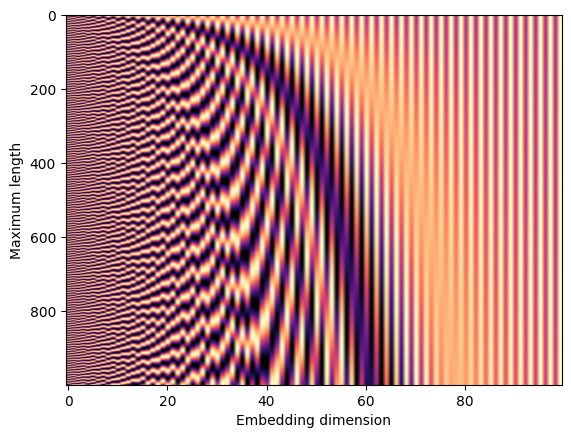

In [13]:
import matplotlib.pyplot as plt
# plt.imshow(pos_embs.squeeze()[:50], cmap='magma') # As in the example above
plt.imshow(pos_embs.squeeze(), cmap='magma')
plt.xlabel('Embedding dimension')
plt.ylabel('Maximum length')
plt.gca().set_aspect('auto', adjustable='box')
plt.show()

## Encoder and decoder


Embedding layers and positional encoding are used both in the Encoder and Decoder part of the Transformer architecture.

The key difference wrt recurrent networks is the attention mechanism, also present in both encoder and decoder.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ArTXQZip_TwbU6gLshXOEw.png">

For each token we create a Query vector $q$ a key vector $k$ and a value vector $v$, through linear transformation. Stacking these vectors we obtain the corresponding matrices $Q$, $K$, $V$.

Self attention is then computed as:

$$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{\text{d}_{k}}}\right) V
$$

The $QK^T$ matrix multiplication computes the relevance between each pair of words (attention weights).

This relevance is then used as a "factor" to compute the weighted sum of all the values words.

This is done in parallel multiple times, for multiple heads (`nhead`). The idea is to capture different aspects of the input.

Self-attention is present both in the encoder and decoder parts of the network, with some key differences:

- For the encoder self-attention the input sequence pays attention to itself: masking is done only on PAD tokens, to avoid attention weight on padding.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*026nzf4bw_DdSZ7kLJWcog.png">

- For the decoder, multi head attention is present twice:
  - Right after positional encoding, we have an attention mechanism where the the output sequence pays attention to itself. The mask is defined so that it will prevent the model from looking into future words when making predictions (masked self-attention). Padding is also masked. Said in other words, in the Decoder, Self-attention masking serves to prevent the decoder from ‘peeking’ ahead at the rest of the target sentence when predicting the next word.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*cawtdZLjT9hp7ByG2vcKOQ.png">

  - After the previous attention mechanism, the Q matrix arrives from it, while K and V from the Encoder. In practice, In the Encoder-Decoder Attention, the Query is obtained from the target sentence and the Key/Value from the source sentence. Thus it computes the relevance of each word in the target sentence to each word in the source sentence.


  The masking is done as per the encoder part here, being careful about padding.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*OYi49Pkg-Vl3D4HleEuu7g.png">


**Note**: not in images, but an encoded \<EOS\> token would be present at the end of each sequence in the encoder, while an encoded \<BOS\> token is present in the decoder at the start of each sequence.

Keep in mind that the decoder part of the Transformers works differently when in training (teacher-forcing) and when in inference mode (autoregressive)



This process is then followed by a normalization layer, skip connections, feedforward and again normalization layer + skip connection.

Multiple encoder (`num_encoder_layers`) and decoder (`num_decoder_layers`) layers are stacked. **Note that dimension of the representation of the sequence is preserved through the architecture**.
Finally, the output of the Transformer model is passed through
a linear layer that gives unnormalized probabilities for each token in the
target language.

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*dQTK3oeYqOBUDVgNktSpCw.png" height=600 width=750>

the [Transformer](https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html) model is easily implemented with its Pytorch class.

In [14]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1,
                 batch_first: bool = True):
        super(Seq2SeqTransformer, self).__init__()
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=batch_first)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src)) # [B, src_seq_len, E] (Batch, src_seq_len, Embedding)
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg)) # [B, tgt_seq_len, E]
        outs = self.transformer(src_emb,
                                tgt_emb,
                                # Attention masks
                                src_mask,
                                tgt_mask,
                                None, # memory mask parameter (decoder cross-attention)
                                # Prevent attention computation on padding tokens
                                src_padding_mask,
                                tgt_padding_mask,
                                memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

Let\'s now define the parameters of our model and instantiate the same.
Below, we also define our loss function which is the cross-entropy loss
and the optimizer used for training.


In [15]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_src)
TGT_VOCAB_SIZE = len(vocab_tgt)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128 # ~10GB of VRAM
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(DEVICE)

Define the loss function and the optimizer. Remember, the loss should ignore padding; take a look at the Pytorch documentation of the appropriate loss (which one should you use for multi-class classification?) in order to understand how to do it.

Also, how would you check if your model is too large or if everything you expect is within the model?

In [ ]:
# loss_fn = # TODO

# optimizer = # TODO

# # TODO

## Solution

In [16]:
# Cross entropy is not computed for the padded part of the sentence.
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

I always find interesting to keep track of the number of trainable parameters when I'm deciding the hyperparameters of a model:

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{(count_parameters(model) / 10**6):.2f}M")

57.71M


Instead if you want a more complete overview of the model:

In [18]:
print(model)

Seq2SeqTransformer(
  (src_tok_emb): TokenEmbedding(
    (embedding): Embedding(30000, 512)
  )
  (tgt_tok_emb): TokenEmbedding(
    (embedding): Embedding(28998, 512)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplac

Collation
=========

As seen in the `Data Downloading and Processing` section, our data iterator yields a pair of raw strings.
We need to convert these string pairs into the batched tensors that can be processed by our `Seq2Seq` network defined previously.
Below we define our collate function that converts a batch of raw strings into batch tensors that can be fed directly into our model.


In [19]:
def tokenize_example(example):
    src = tokenizer_src(
        example[SRC_LANGUAGE],
        add_special_tokens=False) # Avoid adding CLS/SEP from the BERT tokenizer

    tgt = tokenizer_tgt(
        example[TGT_LANGUAGE],
        add_special_tokens=False) # Avoid adding CLS/SEP from the BERT tokenizer.

    # Now, we add [BOS] and [EOS]
    tgt_ids = [tokenizer_tgt.bos_token_id] + tgt['input_ids'] + [tokenizer_tgt.eos_token_id]

    return {
        "input_ids_src": src['input_ids'],
        "input_ids_tgt": tgt_ids,
    }

tokenized = hf_multi30k.map(tokenize_example, batched=False, remove_columns=hf_multi30k['train'].column_names)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [20]:
src_tokens = tokenized['train'][0]['input_ids_src']
tgt_tokens = tokenized['train'][0]['input_ids_tgt']
tokenizer_src.convert_ids_to_tokens(src_tokens), tokenizer_tgt.convert_ids_to_tokens(tgt_tokens)

(['Zwei',
  'junge',
  'weiße',
  'Männer',
  'sind',
  'im',
  'Freien',
  'in',
  'der',
  'Nähe',
  'vieler',
  'Bü',
  '##sche',
  '.'],
 ['[BOS]',
  'Two',
  'young',
  ',',
  'White',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '[EOS]'])

Given the transform helper functions above, how would you define a collate function, which will be given to the DataLoaders, to appropriately prepare batches? Remember to also pad sequences with the ``pad_sequence`` function, imported from ``torch.nn.utils.rnn``.

In [ ]:
# def collate_fn(batch):
#   pass # TODO

## Solution

In [21]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Convert token IDs to tensors
    src_seqs = [torch.tensor(example['input_ids_src']) for example in batch]
    tgt_seqs = [torch.tensor(example['input_ids_tgt']) for example in batch]

    # Pad the source and the target
    src_padded = pad_sequence(src_seqs, batch_first=True, padding_value=tokenizer_src.pad_token_id)
    tgt_padded = pad_sequence(tgt_seqs, batch_first=True, padding_value=tokenizer_tgt.pad_token_id)

    return {
        "input_ids_src": src_padded,
        # "attention_mask_src": src_mask,
        "input_ids_tgt": tgt_padded,
        # "attention_mask_tgt": tgt_mask
    }

# Masking functions

In [22]:
def create_mask(src, tgt):
    src_seq_len = src.shape[1] # [Batch dim, Sequence length]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt_seq_len, device=DEVICE)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX_SRC) # [Batch size, sequence length]
    tgt_padding_mask = (tgt == PAD_IDX_TGT) # [Batch size, sequence length]
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Example

In [ ]:
example_src = 10*torch.rand(5,5)
example_tgt = 5*torch.rand(5,5)
# Put some padding tokens
example_src[3:,-2:] = PAD_IDX_SRC
example_tgt[2:,-1:] = PAD_IDX_TGT

print("example_src\n", example_src)
print("example_tgt\n", example_tgt)

# Compute the masks
src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(example_src, example_tgt)

example_src
 tensor([[9.1140, 3.8354, 4.7665, 6.8479, 3.0648],
        [4.8960, 2.2092, 3.3374, 4.8782, 9.9941],
        [3.6643, 3.4645, 0.4654, 1.9645, 0.1600],
        [3.8243, 1.6387, 1.0004, 0.0000, 0.0000],
        [3.9472, 7.0073, 9.0985, 0.0000, 0.0000]])
example_tgt
 tensor([[2.3766, 2.5385, 2.4919, 4.1884, 2.9207],
        [0.3512, 1.4124, 0.3562, 4.8736, 0.2855],
        [3.0243, 3.2835, 3.6289, 2.3608, 0.0000],
        [3.8651, 0.8942, 0.3834, 4.3596, 0.0000],
        [4.2306, 0.1578, 1.2383, 1.9305, 0.0000]])


In [ ]:
print("src_mask\n", src_mask)
print("tgt_mask\n", tgt_mask)
print("\nPadding masks:")
print("src_padding_mask\n", src_padding_mask)
print("tgt_padding_mask\n", tgt_padding_mask)

src_mask
 tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]], device='cuda:0')
tgt_mask
 tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]], device='cuda:0')

Padding masks:
src_padding_mask
 tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False,  True,  True],
        [False, False, False,  True,  True]])
tgt_padding_mask
 tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False,  True],
        [False, False, False, False,  True],
        [False, False, False, False,  True]])


🛑 Depending on the PyTorch version, the masking behaviour may change. Check the documentation available!

In this notebook, we are running <u>torch 2.9.0</u>

Documentation: https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html

# Training and inference functions

Let\'s define training and evaluation loop that will be called for each
epoch.

Note that in the validation epoch we also compute [perplexity](https://medium.com/nlplanet/two-minutes-nlp-perplexity-explained-with-simple-probabilities-6cdc46884584).


In [23]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized['train'],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn)

valid_loader = DataLoader(
    tokenized['validation'],
    batch_size=BATCH_SIZE, # To make sure it fits the memory
    shuffle=False,
    collate_fn=collate_fn)

batch = next(iter(train_loader))
print("Batch keys", batch.keys())
print("Shapes of source and target:", batch['input_ids_src'].shape, batch['input_ids_tgt'].shape)

Batch keys dict_keys(['input_ids_src', 'input_ids_tgt'])
Shapes of source and target: torch.Size([128, 38]) torch.Size([128, 29])


In [24]:
def train_step(model, batch, optimizer, device, loss_fn, tgt_pad_id):

    model.train()

    src = batch["input_ids_src"].to(device)
    tgt = batch["input_ids_tgt"].to(device)

    # Shift target, teacher forcing
    tgt_input = tgt[:, :-1]
    tgt_output = tgt[:, 1:]

    # Masks
    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    # Forward pass
    logits = model(
        src,
        tgt_input,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask, # padding mask for the target. It is already aligned as we build it from tgt_input
        src_padding_mask  # memory key padding mask: mask the padding tokens during attention computation when the decoder attends to the encoder's output.
        )

    loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


def evaluate(model, val_dataloader):
    model.eval()
    losses = 0
    total_loss = 0
    tot_tokens = 0

    for batch in val_dataloader:
        src = batch['input_ids_src'].to(DEVICE)
        tgt = batch['input_ids_tgt'].to(DEVICE)

        # Teacher forcing
        tgt_input = tgt[:, :-1,]
        tgt_out = tgt[:, 1:]

        # Compute the masks
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        # Count the target tokens ignoring padding index
        num_tokens = (tgt_out != PAD_IDX).sum().item()

        losses += loss.item() * num_tokens # To avoid bias when batches have different size
        total_loss += loss.item()
        tot_tokens += num_tokens

    avg_loss = losses / tot_tokens
    perplexity = math.exp(avg_loss)

    return total_loss, perplexity

Let's also write a couple functions to greedily decode sequences produced by the model.

In [25]:
def greedy_decode(model, src_tokens, src_mask, max_len, start_symbol, end_symbol, device):
    model.eval()

    # Encode the source
    memory = model.encode(src_tokens, src_mask)

    # Initialize target with BOS
    ys = torch.tensor([[start_symbol]], dtype=torch.long, device=device)

    for _ in range(max_len):
        # Build autoregressive mask for the current target length
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(ys.size(1), device)

        # Decode
        out = model.decode(ys, memory, tgt_mask)

        # Get logits for last timestep
        logits = model.generator(out[:, -1])     # shape (1, vocab)

        # Greedy: pick best token
        next_word = logits.argmax(dim=1).item()

        # Append to output sequence
        ys = torch.cat(
            [ys, torch.tensor([[next_word]], dtype=torch.long, device=device)],
            dim=1
        )

        # Stop if EOS
        if next_word == end_symbol:
            break

    return ys

def translate(model, sentence, src_tokenizer, tgt_tokenizer, device=DEVICE, max_len=100):
    model.eval()

    # Tokenize without padding
    src_tokens = src_tokenizer(
        sentence,
        padding=False,
        truncation=True,
        return_tensors="pt"
    )["input_ids"].to(device)

    # Build src mask
    src_mask = torch.zeros((src_tokens.size(1), src_tokens.size(1)),
                           dtype=torch.bool, device=device)

    # Greedy decoding
    ys = greedy_decode(
        model,
        src_tokens,
        src_mask,
        max_len=max_len,
        start_symbol=tgt_tokenizer.bos_token_id,
        end_symbol=tgt_tokenizer.eos_token_id,
        device=device
    )

    # Convert token IDs to string without taking into account special tokens (e.g., [PAD] or [BOS])
    return tgt_tokenizer.decode(ys.squeeze().tolist(), skip_special_tokens=True)

Write a function to qualitatively evaluate the quality of the translation of a single sentence, from the validation set, from the model. This is going to be used at the end of every training epoch to have a general idea of how / if the model is improving. Use the functions defined above within it.

In [ ]:
# def evaluate_single_sentence():
#   pass #TODO

## Solution

In [26]:
def evaluate_single_sentence(model, tokenizer_src, tokenizer_tgt):
    model.eval()

    val_iter = tokenized['validation']
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    batch = next(iter(val_dataloader))
    src = batch['input_ids_src'].to(DEVICE)
    tgt = batch['input_ids_tgt'].to(DEVICE)

    src_sample = src[0]
    tgt_sample = tgt[0]

    src_sentence = tokenizer_src.decode(src_sample, skip_special_tokens=True)
    tgt_sentence = tokenizer_tgt.decode(tgt_sample, skip_special_tokens=True)
    translation = translate(model, src_sentence, tokenizer_src, tokenizer_tgt, DEVICE)

    return src_sentence, tgt_sentence, translation

In [27]:
val_batch = next(iter(valid_loader))

print(val_batch['input_ids_src'].shape, val_batch['input_ids_tgt'].shape)
print(tokenizer_src.decode(val_batch['input_ids_src'][0], skip_special_tokens=True))
print(tokenizer_tgt.decode(val_batch['input_ids_tgt'][0], skip_special_tokens=True))

torch.Size([128, 37]) torch.Size([128, 32])
Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
A group of men are loading cotton onto a truck


# Model training

We finally have everything we need to train our Transformer model.

Using all the functions defined above, train the transformer model for 20 epochs, keep track of training and validation losses at every epoch, as they will be useful to evaluate the model afterwards.

Make sure to print out essential information during the training.
For each epoch you should print out:

- Epoch number
- Training loss
- Validation loss
- Perplexity
- A single source sentence
- The corresponding target sentence
- The translation of the model for that sentence
- Optionally the amount of time for the epoch


The training should take approximately 15-20 minutes (with Colab's GPU).


In [ ]:
# from timeit import default_timer as timer
# import warnings
# warnings.filterwarnings("ignore")

# NUM_EPOCHS = 20

# training_losses = # TODO
# val_losses = # TODO

# print("Untrained model")
# source, target, translation = evaluate_single_sentence(model, 0, tokenizer_src, tokenizer_tgt)

# print("*"*20)
# print("Training")
# print("*"*20)

# for epoch in range(1, NUM_EPOCHS+1):
#     start_time = timer()


#     # TODO


#     end_time = timer()

## Solution

In [28]:
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

NUM_EPOCHS = 20

training_losses = []
val_losses = []

print("Untrained model")
source, target, translation = evaluate_single_sentence(model, tokenizer_src, tokenizer_tgt)
print(f"Source: {source}")
print(f"Target: {target}")
print(f"Translation: {translation}")
print("\n\n")

print("*"*20)
print("Training")
print("*"*20)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = 0
    for batch in train_loader:
        loss = train_step(model, batch, optimizer, DEVICE, loss_fn, PAD_IDX_TGT)
        train_loss += loss
    train_loss /= len(train_loader)
    end_time = timer()
    val_loss, perplexity = evaluate(model, valid_loader)
    val_loss /= len(valid_loader)
    print(f"Epoch: {epoch}")
    print(f"Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Perplexity: {perplexity}")
    print(f"Epoch time = {(end_time - start_time):.3f}s")
    training_losses.append(train_loss)
    val_losses.append(val_loss)
    source, target, translation = evaluate_single_sentence(model, tokenizer_src, tokenizer_tgt)

    print(f"Source: {source}")
    print(f"Target: {target}")
    print(f"Translation: {translation}")
    print("\n\n")

Untrained model
Source: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target: A group of men are loading cotton onto a truck
Translation: [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [unused71] [u

# Model evaluation

As usual let's plot out the evolution of the training and validation losses

In [ ]:
# import matplotlib.pyplot as plt

# # TODO

## Solution

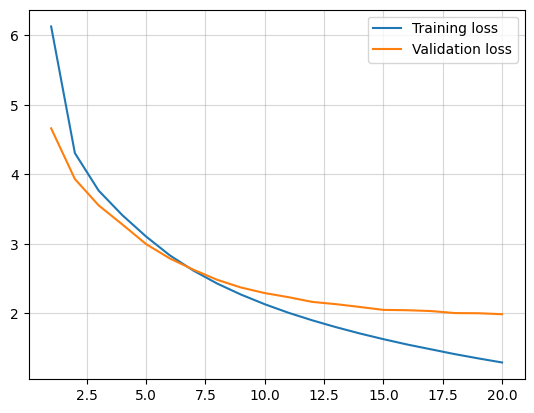

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(1,NUM_EPOCHS+1),training_losses, label="Training loss")
plt.plot(range(1,NUM_EPOCHS+1),val_losses, label="Validation loss")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Test translation

Let's test the translation with a few sentences, different conditions:

In [30]:
# For a sentence we know it's in the dataset
print("In dataset")
print(translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .", tokenizer_src, tokenizer_tgt)) # A group of people stands in front of an igloo.
# For some sentences that are appropriate for the dataset type (image captions)
print("In appropriate context")
print(translate(model, "Ein rotes Auto rast auf der Autobahn", tokenizer_src, tokenizer_tgt)) # A red car is racing on the highway
print(translate(model, "Ein kleiner Junge, der mit einem Ball spielt", tokenizer_src, tokenizer_tgt)) # A little boy playing with a ball
# Something completely different, a statement
print("Out of domain")
print(translate(model, "Der Präsident des Verbandes kündigte eine Konferenz an", tokenizer_src, tokenizer_tgt)) # The president of the association announced a conference
# Something that could be from a messaging app
print(translate(model, "Wir sehen uns morgen um 18 Uhr in der Nähe des städtischen Schwimmbades", tokenizer_src, tokenizer_tgt)) # See you tomorrow at 6 p.m. near the municipal swimming pool

In dataset
A group of people standing in front of an igregate.
In appropriate context
A red car shaving on the highway in the highway.
A little boy playing with a ball, who is playing a tambourine.
Out of domain
The tourist is standing at a conference table that has been various pictures of the political fan at the conference table.
Protesters watch this photo of people in the urban setting looking like they are watching their parents ' s watch them that says strollers close close close to see close close close to see close close to see close their parents ' s company.


You can try also with your own test sentences:

In [ ]:
# my_sentence = # TODO (note that this should be in German)
# print(translate(model, my_sentence, tokenizer_src, tokenizer_tgt))

We've seen a lot in this exercise, but as you can see the model is limited. After all you wouldn't expect to solve machine translation on a laptop in 30 minutes, right?
If you want you can try several things:
- change minumum number of times a word has to appear in the training set to be included in the vocabulary
- change tokenizers
- change hyperparameters of the transformer architecture (**emb size**, **ffnn_dim**, n_enc, n_dec, ...)
- change training hyperparameters (batch size, number of epochs)
- implement other evaluation metrics (e.g. [BLEU score](https://en.wikipedia.org/wiki/BLEU))
- implement a different way to generate sequences in inference (e.g.[ Beam search](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24))
- You can also use this notebook as a starting point for a different machine translation dataset / task, the steps are approximately the same.

References
==========

1. [Multi30K: Multilingual English-German Image Descriptions](https://arxiv.org/abs/1605.00459)
2. Attention is all you need paper.
    <https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>
3.  The annotated transformer.
    <https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding>
4.  Blogpost transformers explained https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452
5.  Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient estimation of word representations in vector space. <https://arxiv.org/abs/1301.3781>
6.  Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. <https://proceedings.neurips.cc/paper/2014/hash/a14ac55a4f27472c5d894ec1c3c743d2-Abstract.html>
7.  Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to alignand translate. <https://arxiv.org/abs/1409.0473>
8.  He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. <https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html>
9.  Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016). Layer normalization. <https://arxiv.org/abs/1607.06450>
10.  Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory <https://ieeexplore.ieee.org/abstract/document/6795963>
